In [1]:
import os
import sys
import getopt

import parse_genet
import vi

import importlib

import simulate
import torch
import matplotlib.pyplot as plt
import numpy as np

import pyro.distributions as dist

import scipy.stats

import pandas as pd
import numpy as np
import string
import random
import time

In [10]:
param_dict = {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur', ## add my path
    'bim_prefix' : "test_data/test",
    'sst_file' : "test_data/sumstats.txt",
    'n_gwas' : 200000, 
    'out_dir' : "test_data",
    "seed" : 42, 
    "beta_std" : "False", 
    "n_iter" : 1000, 
    'anno_path': '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/annotations/annotations_high_h2/baseline/baseline_high_h2_chr'
}

In [43]:
# importlib.reload(simulate)
# importlib.reload(parse_genet)
# def check_sim_result(param_dict, title, chrom=22):
#     if '1kg' in os.path.basename(param_dict['ref_dir']):
#         ref_df = parse_genet.parse_ref(param_dict['ref_dir'] + '/snpinfo_1kg_hm3')
#     elif 'ukbb' in os.path.basename(param_dict['ref_dir']):
#         ref_df = parse_genet.parse_ref(param_dict['ref_dir'] + '/snpinfo_ukbb_hm3')

#     ref_df = ref_df[ref_df.CHR == chrom]
#     vld_df = parse_genet.parse_bim(param_dict['bim_prefix'] + ".bim")
#     vld_df = vld_df[vld_df.CHR == chrom]
#     sst_dict = parse_genet.parse_sumstats(ref_df, vld_df, param_dict['sst_file'], param_dict['n_gwas'])
#     ld_blk, ld_blk_sym, blk_size = parse_genet.parse_ldblk(param_dict['ref_dir'], sst_dict, chrom)                                                                                                                                                                      
#     print("There are %s ld_block. \n" %(len(ld_blk)))
    
#     beta_true, beta_mrg, annotations, anno_names = simulate.simulate_sumstats(ld_blk, blk_size, param_dict['n_gwas'], len(sst_dict), sst_dict,anno_path = param_dict['anno_path'])
#     sst_dict["BETA"] = beta_mrg
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
#     anno_names = anno_names.insert(0,'intercept')

#     importlib.reload(vi)
#     one = torch.tensor(1., device=device)
#     losses, beta, phi_est, stats = vi.vi(sst_dict, param_dict['n_gwas'], ld_blk, blk_size, device = device, annotations = annotations, max_iterations = param_dict['n_iter'], max_particles=4, desired_min_eig = 1e-3, min_iterations = 200, stall_window = 30, phi_as_prior = False, lr = 0.03, constrain_sigma = True)
    
#     plt.plot(losses); plt.show()
#     plt.scatter(beta_true, beta)
#     plt.xlabel("True beta")
#     plt.ylabel("Infered beta")
#     plt.title("Pearson R=%1.3f" % scipy.stats.pearsonr(beta_true,beta)[0])
   
    
#     ## check anno
#     anno_df = pd.DataFrame.from_dict(stats["annotation_weights"] )
#     print(anno_df)
#     anno_plot = anno_df.reset_index().plot(x="index", y = 'mean', yerr='std',kind="bar", color='lightskyblue', title = title, ylabel='weight', xlabel='annotation')
#     anno_plot.set_xticklabels(anno_names,rotation=30)
#     print(anno_plot)
#     print(stats["annotation_weights"]) # ideally should show large positive value for second entry, and close to 0 for third (noise)

#     # convert standardized beta to per-allele beta
#     if param_dict["beta_std"] == 'False':
#         beta /= np.sqrt(2.0*sst_dict['MAF']*(1.0-sst_dict['MAF']))

#     sst_dict["beta_shrunk"] = beta

In [118]:
importlib.reload(simulate)
importlib.reload(parse_genet)

## add annotations, add iteration. add path for saving the plot
def check_sim_result(param_dict, title, chrom=22, refit_time=1):
    name = ''.join(random.choices(string.ascii_lowercase +string.digits, k=3))
    path='/gpfs/commons/home/tlin/pic/casioPR/simulation/' + param_dict['save_fig_path'] + '_'+name+'_'
    print("save fig in %s"%path)
    if '1kg' in os.path.basename(param_dict['ref_dir']):
        ref_df = parse_genet.parse_ref(param_dict['ref_dir'] + '/snpinfo_1kg_hm3')
    elif 'ukbb' in os.path.basename(param_dict['ref_dir']):
        ref_df = parse_genet.parse_ref(param_dict['ref_dir'] + '/snpinfo_ukbb_hm3')

    ref_df = ref_df[ref_df.CHR == chrom]
    vld_df = parse_genet.parse_bim(param_dict['bim_prefix'] + ".bim")
    vld_df = vld_df[vld_df.CHR == chrom]
    sst_dict = parse_genet.parse_sumstats(ref_df, vld_df, param_dict['sst_file'], param_dict['n_gwas'])
    ld_blk, ld_blk_sym, blk_size = parse_genet.parse_ldblk(param_dict['ref_dir'], sst_dict, chrom)                                                                                                                                                                      
    print("There are %s ld_block. \n" %(len(ld_blk)))
    
    beta_true, beta_mrg, annotations, anno_names = simulate.simulate_sumstats(ld_blk, blk_size, param_dict['n_gwas'], len(sst_dict), sst_dict,anno_path = param_dict['anno_path'], chrom=chrom)
    sst_dict["BETA"] = beta_mrg
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    anno_names = anno_names.insert(0,'intercept')

    importlib.reload(vi)
    #one = torch.tensor(1., device=device)
    
    pearsonr_list=[]
    anno_list=pd.DataFrame()

    for i in range(refit_time):
        losses, beta, phi_est, stats = vi.vi(sst_dict, param_dict['n_gwas'], ld_blk, blk_size, device = device, annotations = annotations, max_iterations = param_dict['n_iter'], max_particles=4, desired_min_eig = 1e-3, min_iterations = 200, stall_window = 30, phi_as_prior = False, lr = 0.03, constrain_sigma = True)
        plt.plot(losses);plt.title('losses');plt.savefig(path+'loss_%s.png'%i); plt.show()
        r=scipy.stats.pearsonr(beta_true,beta)[0]
        pearsonr_list.append(r)

        ## check anno
        anno_df = pd.DataFrame.from_dict(stats["annotation_weights"] )
        anno_list = anno_list.append(anno_df["mean"].to_frame().T, ignore_index=True)  
    
    ## plot anno  
    plt.bar(anno_list.mean().index, anno_list.mean(), yerr=anno_list.std(), capsize=3, color='turquoise')
    plt.xticks(anno_list.mean().index, anno_names, rotation=90)
    
    plt.ylabel('weight')
    plt.title('iterate %d times'%(refit_time))
    plt.show()
    plt.savefig(path+'anno_weight.pdf',format ='pdf')
    print(stats["annotation_weights"]) # ideally should show large positive value for second entry, and close to 0 for third (noise)

    ## plot r
    plt.plot(range(refit_time), pearsonr_list, marker='o', linestyle='--', color='c')
    ax = plt.axes()
    ax.set_ylim(0.5, 1)
    plt.xticks(list(range(refit_time)),list(range(1,refit_time+1)))
    plt.title('pearson r for betas in every iteration')
    plt.savefig(path+'anno_weight.pdf',format ='pdf')
    plt.show()

    print(pearsonr_list)
    return(anno_list,pearsonr_list)        

... parse reference file: /gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur/snpinfo_ukbb_hm3 ...
... parse sumstats file: test_data/sumstats.txt ...
... 991 common SNPs in the reference, sumstats, and validation set ...
There are 4 ld_block. 

... parse annotations ...
Reading annotations from 1 file(s)... 
Successfully loaded 5 annotations for 271699 SNPs
Total of 991 SNPs left after merging with sst
Done in 0.48 seconds 

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 239 iterations. Increasing num_particles to 2.
Done after 69 iterations. Increasing num_particles to 4.
Done after 289 iterations. Increasing num_particles to 8.
Done in 41.82 seconds 



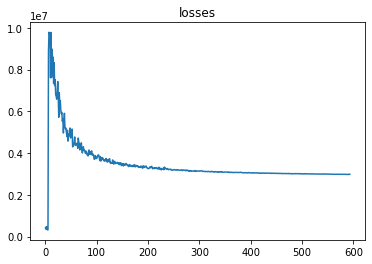

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 273 iterations. Increasing num_particles to 2.
Done after 125 iterations. Increasing num_particles to 4.
Done after 48 iterations. Increasing num_particles to 8.
Done in 21.19 seconds 



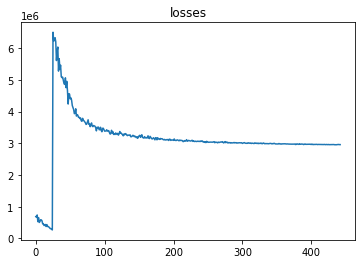

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 214 iterations. Increasing num_particles to 2.
Done after 75 iterations. Increasing num_particles to 4.
Done after 85 iterations. Increasing num_particles to 8.
Done in 20.25 seconds 



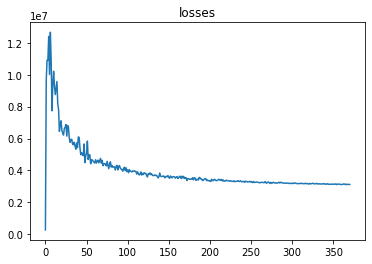

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 227 iterations. Increasing num_particles to 2.
Done after 56 iterations. Increasing num_particles to 4.
Done after 139 iterations. Increasing num_particles to 8.
Done in 25.53 seconds 



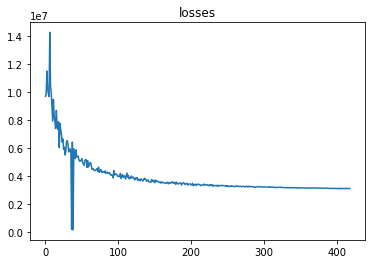

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 216 iterations. Increasing num_particles to 2.
Done after 88 iterations. Increasing num_particles to 4.
Done after 241 iterations. Increasing num_particles to 8.
Done in 37.25 seconds 



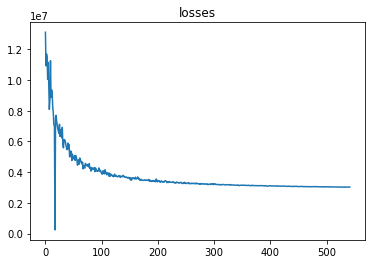

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 410 iterations. Increasing num_particles to 2.
Done after 112 iterations. Increasing num_particles to 4.
Done after 336 iterations. Increasing num_particles to 8.
Done in 54.34 seconds 



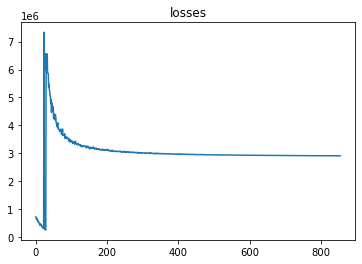

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 215 iterations. Increasing num_particles to 2.
Done after 49 iterations. Increasing num_particles to 4.
Done after 86 iterations. Increasing num_particles to 8.
Done in 18.97 seconds 



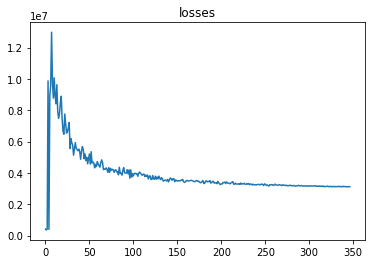

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 265 iterations. Increasing num_particles to 2.
Done after 82 iterations. Increasing num_particles to 4.
Done after 124 iterations. Increasing num_particles to 8.
Done in 26.42 seconds 



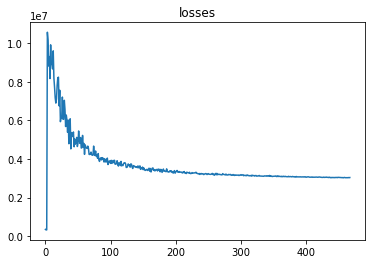

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 227 iterations. Increasing num_particles to 2.
Done after 60 iterations. Increasing num_particles to 4.
Done after 98 iterations. Increasing num_particles to 8.
Done in 21.17 seconds 



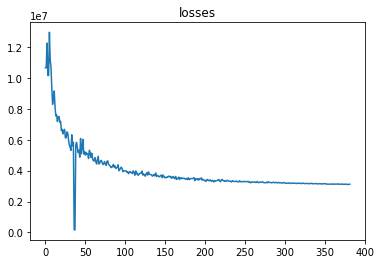

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 224 iterations. Increasing num_particles to 2.
Done after 126 iterations. Increasing num_particles to 4.
Done after 256 iterations. Increasing num_particles to 8.
Done in 41.15 seconds 



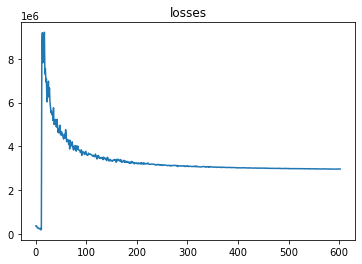

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 204 iterations. Increasing num_particles to 2.
Done after 176 iterations. Increasing num_particles to 4.
Done after 238 iterations. Increasing num_particles to 8.
Done in 42.40 seconds 



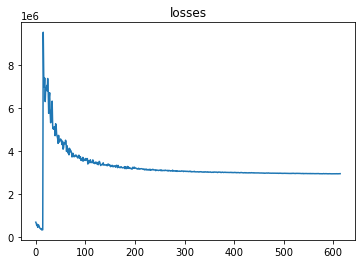

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 258 iterations. Increasing num_particles to 2.
Done after 90 iterations. Increasing num_particles to 4.
Done after 147 iterations. Increasing num_particles to 8.
Done in 29.37 seconds 



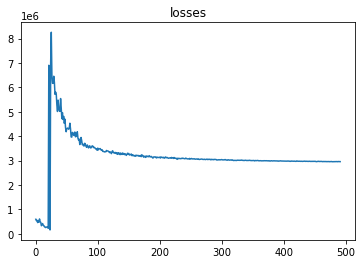

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 270 iterations. Increasing num_particles to 2.
Done after 170 iterations. Increasing num_particles to 4.
Done after 319 iterations. Increasing num_particles to 8.
Done in 51.55 seconds 



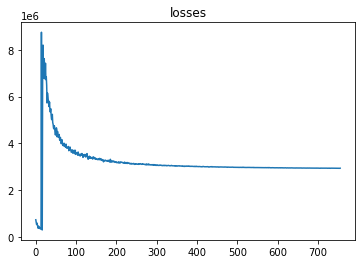

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 237 iterations. Increasing num_particles to 2.
Done after 47 iterations. Increasing num_particles to 4.
Done after 106 iterations. Increasing num_particles to 8.
Done in 21.65 seconds 



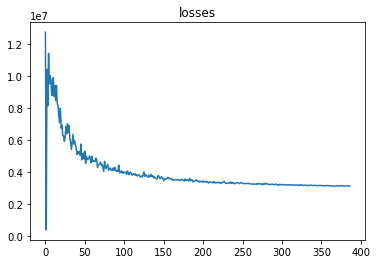

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 244 iterations. Increasing num_particles to 2.
Done after 212 iterations. Increasing num_particles to 4.
Done after 168 iterations. Increasing num_particles to 8.
Done in 37.97 seconds 



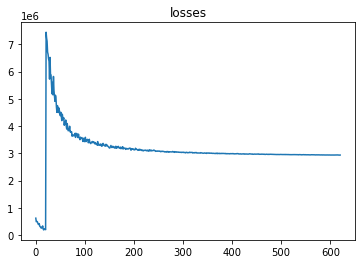

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 301 iterations. Increasing num_particles to 2.
Done after 277 iterations. Increasing num_particles to 4.
Done after 124 iterations. Increasing num_particles to 8.
Done in 37.70 seconds 



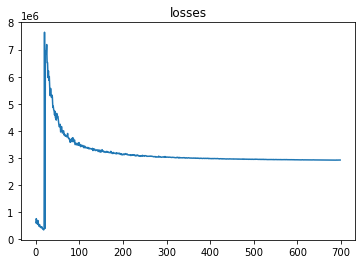

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 215 iterations. Increasing num_particles to 2.
Done after 185 iterations. Increasing num_particles to 4.
Done after 210 iterations. Increasing num_particles to 8.
Done in 39.36 seconds 



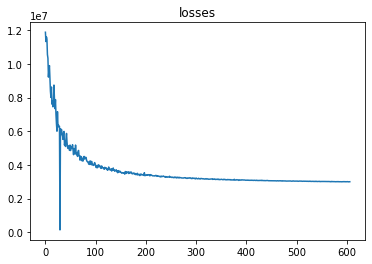

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 204 iterations. Increasing num_particles to 2.
Done after 53 iterations. Increasing num_particles to 4.
Done after 80 iterations. Increasing num_particles to 8.
Done in 18.53 seconds 



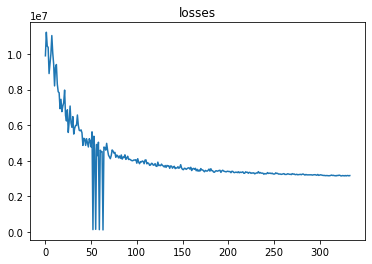

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 250 iterations. Increasing num_particles to 2.
Done after 162 iterations. Increasing num_particles to 4.
Done after 159 iterations. Increasing num_particles to 8.
Done in 34.24 seconds 



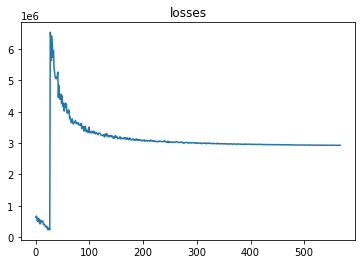

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 203 iterations. Increasing num_particles to 2.
Done after 71 iterations. Increasing num_particles to 4.
Done after 139 iterations. Increasing num_particles to 8.
Done in 25.39 seconds 



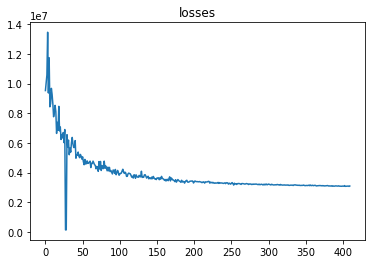

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 461 iterations. Increasing num_particles to 2.
Done after 70 iterations. Increasing num_particles to 4.
Done after 308 iterations. Increasing num_particles to 8.
Done in 50.44 seconds 



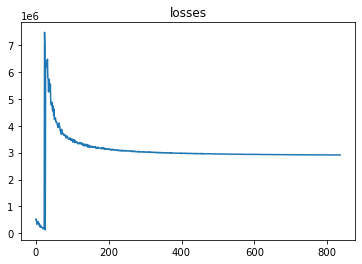

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 235 iterations. Increasing num_particles to 2.
Done after 114 iterations. Increasing num_particles to 4.
Done after 256 iterations. Increasing num_particles to 8.
Done in 40.98 seconds 



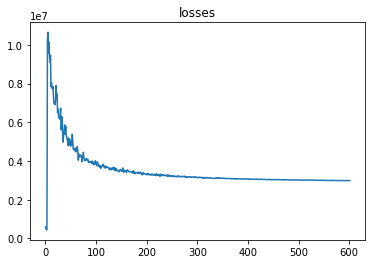

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 255 iterations. Increasing num_particles to 2.
Done after 90 iterations. Increasing num_particles to 4.
Done after 82 iterations. Increasing num_particles to 8.
Done in 22.27 seconds 



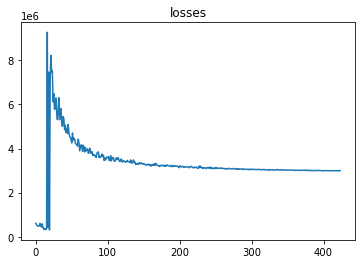

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 306 iterations. Increasing num_particles to 2.
Done after 189 iterations. Increasing num_particles to 4.
Done after 50 iterations. Increasing num_particles to 8.
Done in 25.66 seconds 



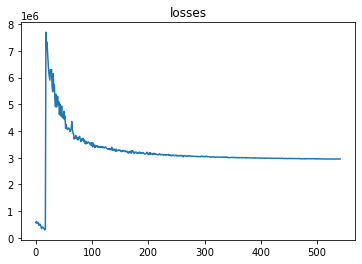

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 209 iterations. Increasing num_particles to 2.
Done after 238 iterations. Increasing num_particles to 4.
Done after 72 iterations. Increasing num_particles to 8.
Done in 27.73 seconds 



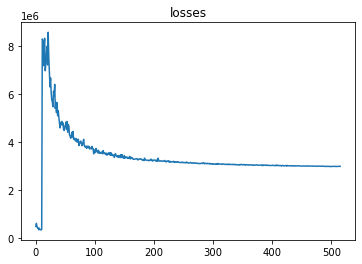

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 202 iterations. Increasing num_particles to 2.
Done after 55 iterations. Increasing num_particles to 4.
Done after 134 iterations. Increasing num_particles to 8.
Done in 24.57 seconds 



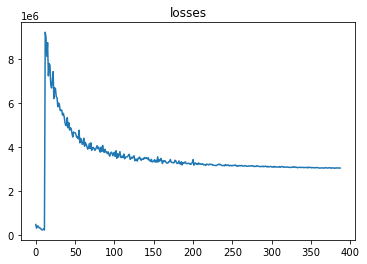

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 222 iterations. Increasing num_particles to 2.
Done after 41 iterations. Increasing num_particles to 4.
Done after 182 iterations. Increasing num_particles to 8.
Done in 29.20 seconds 



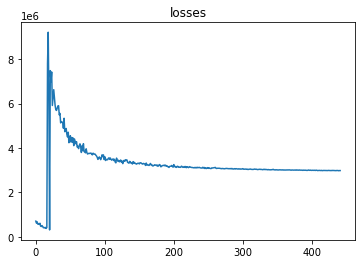

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 209 iterations. Increasing num_particles to 2.
Done after 39 iterations. Increasing num_particles to 4.
Done after 98 iterations. Increasing num_particles to 8.
Done in 19.64 seconds 



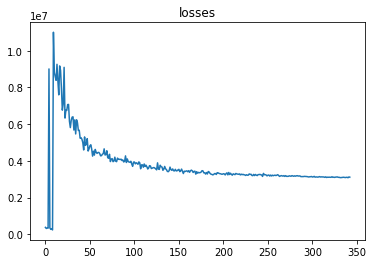

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 217 iterations. Increasing num_particles to 2.
Done after 113 iterations. Increasing num_particles to 4.
Done after 210 iterations. Increasing num_particles to 8.
Done in 36.28 seconds 



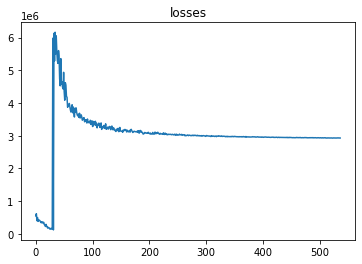

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 238 iterations. Increasing num_particles to 2.
Done after 106 iterations. Increasing num_particles to 4.
Done after 242 iterations. Increasing num_particles to 8.
Done in 39.32 seconds 



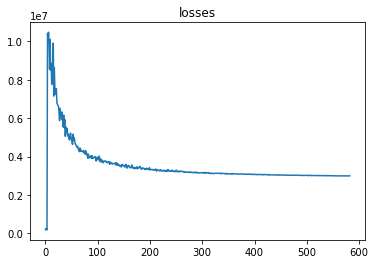

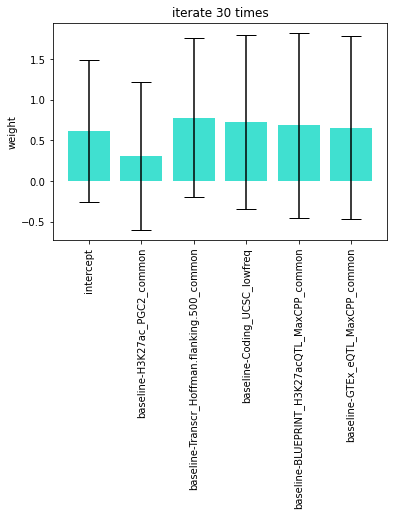

{'mean': tensor([ 1.6905,  1.6337, -0.0829,  0.8144,  0.6867, -0.4746]), 'std': tensor([0.0868, 0.1103, 0.1328, 0.3930, 0.1361, 0.2991]), '5%': tensor([ 1.5400,  1.4636, -0.3087,  0.0183,  0.4802, -0.9782]), '95%': tensor([1.8431, 1.8110, 0.1428, 1.5034, 0.9199, 0.0072])}


/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


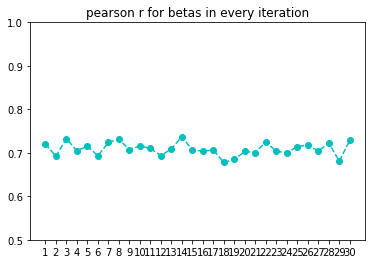

[0.7207382177759558, 0.6921107462366369, 0.7324705105833815, 0.7047523025220698, 0.7149678290645203, 0.6931723231769066, 0.723896358508596, 0.7313272528888018, 0.7074745587505248, 0.7161031886401492, 0.7100635196660762, 0.6938022391828583, 0.7089112090832069, 0.7371984927957186, 0.7064481211014562, 0.7040591114136224, 0.7060786820140931, 0.67783971731854, 0.6846974143085488, 0.7032572279084301, 0.700702968997408, 0.725124392728721, 0.703425244048734, 0.7004734987983118, 0.7142147502475618, 0.7182640504733704, 0.7039586601257669, 0.7222918034550964, 0.6810570186086176, 0.7286850946317163]


In [113]:
param_dict = {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur', ## add my path
    'bim_prefix' : "test_data/test",
    'sst_file' : "test_data/sumstats.txt",
    'n_gwas' : 200000, 
    'out_dir' : "test_data",
    "seed" : 42, 
    "beta_std" : "False", 
    "n_iter" : 1000, 
    'anno_path': '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/annotations/annotations_high_h2/baseline/baseline_high_h2_chr',
    'save_fig_path':'0922/bl_10_iter_1000SNP'      
}

test = check_sim_result(param_dict, "check_anno",refit_time = 30)

save fig in /gpfs/commons/home/tlin/pic/casioPR/simulation/0922/all_anno_10_iter_1000SNP_ax3_
... parse reference file: /gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur/snpinfo_ukbb_hm3 ...
... parse sumstats file: test_data/sumstats.txt ...
... 991 common SNPs in the reference, sumstats, and validation set ...
There are 4 ld_block. 

... parse annotations ...
Reading annotations from 3 file(s)... 
Successfully loaded 28 annotations for 271699 SNPs
Total of 991 SNPs left after merging with sst
Done in 1.86 seconds 

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 225 iterations. Increasing num_particles to 2.
Done after 106 iterations. Increasing num_particles to 4.
Done after 34 iterations. Increasing num_parti

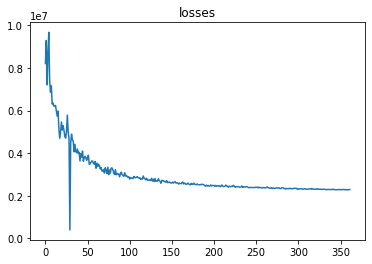

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 258 iterations. Increasing num_particles to 2.
Done after 32 iterations. Increasing num_particles to 4.
Done after 190 iterations. Increasing num_particles to 8.
Done in 30.30 seconds 



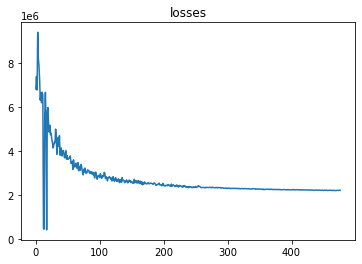

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 218 iterations. Increasing num_particles to 2.
Done after 126 iterations. Increasing num_particles to 4.
Done after 192 iterations. Increasing num_particles to 8.
Done in 34.47 seconds 



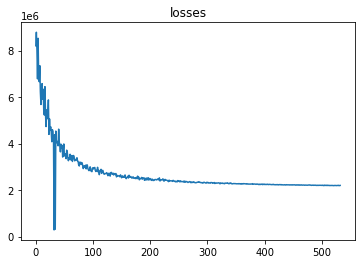

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 212 iterations. Increasing num_particles to 2.
Done after 109 iterations. Increasing num_particles to 4.
Done after 239 iterations. Increasing num_particles to 8.
Done in 38.03 seconds 



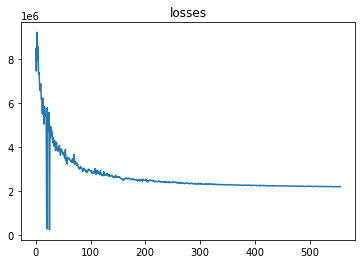

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 230 iterations. Increasing num_particles to 2.
Done after 155 iterations. Increasing num_particles to 4.
Done after 54 iterations. Increasing num_particles to 8.
Done in 21.69 seconds 



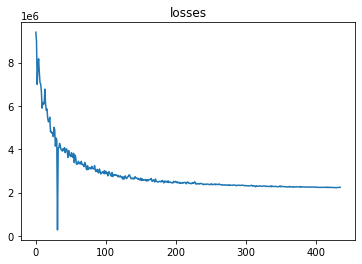

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 213 iterations. Increasing num_particles to 2.
Done after 46 iterations. Increasing num_particles to 4.
Done after 147 iterations. Increasing num_particles to 8.
Done in 25.15 seconds 



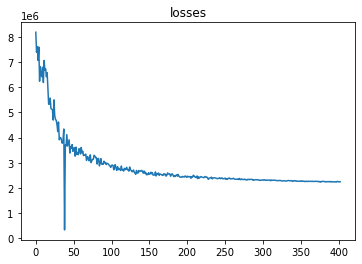

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 279 iterations. Increasing num_particles to 2.
Done after 150 iterations. Increasing num_particles to 4.
Done after 202 iterations. Increasing num_particles to 8.
Done in 38.57 seconds 



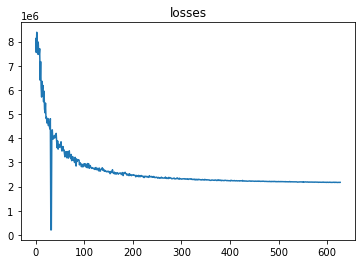

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 301 iterations. Increasing num_particles to 2.
Done after 55 iterations. Increasing num_particles to 4.
Done after 187 iterations. Increasing num_particles to 8.
Done in 32.16 seconds 



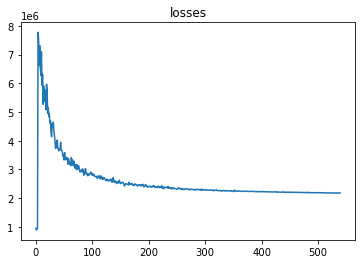

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 263 iterations. Increasing num_particles to 2.
Done after 113 iterations. Increasing num_particles to 4.
Done after 190 iterations. Increasing num_particles to 8.
Done in 34.74 seconds 



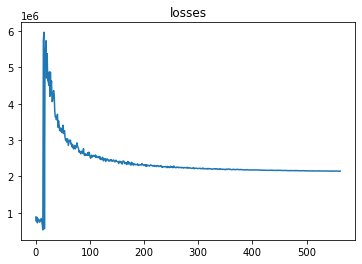

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 204 iterations. Increasing num_particles to 2.
Done after 58 iterations. Increasing num_particles to 4.
Done after 59 iterations. Increasing num_particles to 8.
Done in 16.35 seconds 



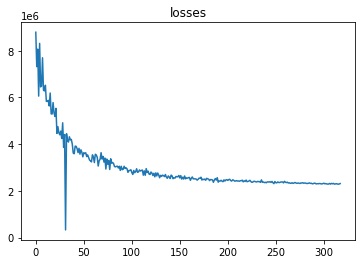

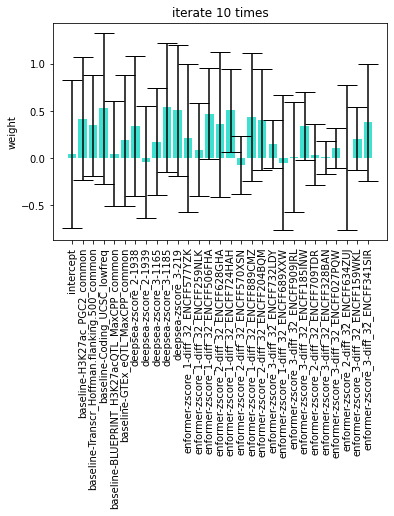

{'mean': tensor([ 0.2343,  0.9342,  0.1906,  0.6516,  0.4040,  0.1063, -0.8138,  0.2719,
         0.3138,  0.0905,  0.5631, -0.1211, -0.0538,  0.5099,  0.2137,  0.6058,
         0.2183,  0.2325,  1.0253,  0.0884, -0.6889,  0.0600,  0.8747,  0.1511,
        -0.0299,  0.5072, -0.2530,  0.1952, -0.0773]), 'std': tensor([0.1883, 0.1896, 0.2853, 0.3575, 0.2885, 0.4339, 0.3348, 0.1892, 0.2179,
        0.2878, 0.1990, 0.3131, 0.2408, 0.5083, 0.3688, 0.2890, 0.2837, 0.5177,
        0.3467, 0.8713, 0.3147, 1.0265, 0.5080, 0.5838, 1.0954, 0.8238, 0.7891,
        0.3417, 0.9865]), '5%': tensor([-0.0647,  0.6265, -0.3596,  0.1068, -0.0575, -0.5796, -1.3619, -0.0870,
        -0.0040, -0.4036,  0.2481, -0.6036, -0.4607, -0.3200, -0.3623,  0.0858,
        -0.2354, -0.5857,  0.2240, -1.4593, -1.2362, -1.5304, -0.0207, -0.9087,
        -1.7899, -0.6788, -1.3976, -0.3727, -1.6698]), '95%': tensor([ 0.5284,  1.2604,  0.5999,  1.1936,  0.9254,  0.7333, -0.2954,  0.6090,
         0.6407,  0.5778,  0.8683, 

/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


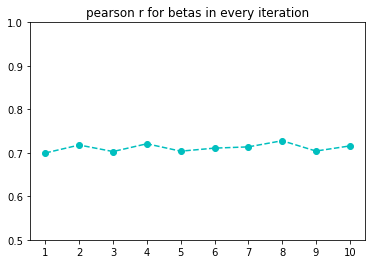

[0.6997114439809355, 0.7179534218393032, 0.702935309269753, 0.7208359607596989, 0.7038053689474298, 0.7107915613154565, 0.7136586903309109, 0.7278236746234383, 0.7040757293818095, 0.7158620678760133]


In [119]:
param_dict = {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur', ## add my path
    'bim_prefix' : "test_data/test",
    'sst_file' : "test_data/sumstats.txt",
    'n_gwas' : 200000, 
    'out_dir' : "test_data",
    "seed" : 42, 
    "beta_std" : "False", 
    "n_iter" : 1000, 
    'anno_path': ','.join([bl_anno,deepsea,enformer]),
    'save_fig_path':'0922/all_anno_10_iter_1000SNP'      
}

test = check_sim_result(param_dict, "check_anno",refit_time = 10)

In [ ]:
param_dict = {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur', ## add my path
    'bim_prefix' : "test_data/test",
    'sst_file' : "test_data/sumstats.txt",
    'n_gwas' : 200000, 
    'out_dir' : "test_data",
    "seed" : 42, 
    "beta_std" : "False", 
    "n_iter" : 1000, 
    'anno_path': ','.join([bl_anno,deepsea,enformer]),
    'save_fig_path':'0922/all_anno_10_iter_1000SNP'      
}

test = check_sim_result(param_dict, "check_anno",refit_time = 10)

In [79]:
##testing

bl_anno='/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/annotations/annotations_high_h2/baseline/baseline_high_h2_chr'
deepsea='/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/annotations/annotations_high_h2/deepsea/deepsea_high_h2_chr'
enformer='/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/annotations/annotations_high_h2/enformer/enformer_high_h2_chr'


... parse reference file: /gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur/snpinfo_ukbb_hm3 ...
... parse sumstats file: test_data/sumstats.txt ...
... 991 common SNPs in the reference, sumstats, and validation set ...
There are 4 ld_blk


In [30]:
importlib.reload(parse_genet)
beta_true, beta_mrg, annotations = simulate_sumstats(ld_blk, blk_size, param_dict['n_gwas'], p = len(sst_dict),sst_dict = sst_dict, anno_path = bl_anno)
sst_dict["BETA"] = beta_mrg
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
importlib.reload(vi)   
one = torch.tensor(1., device=device)

Reading annotations from 1 file(s)... 
Successfully loaded 5 annotations for 271699 SNPs 

Total of 991 SNPs after merging with sst 

Flipping annotaions for 756 rows


In [32]:
losses, beta, phi_est, stats = vi.vi(sst_dict, param_dict['n_gwas'], ld_blk, blk_size, device = device, annotations = annotations.float(), max_iterations = param_dict['n_iter'], max_particles=4, desired_min_eig = 1e-3, min_iterations = 200, stall_window = 30, phi_as_prior = False, lr = 0.03, constrain_sigma = True)

... SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 367 iterations. Increasing num_particles to 2.
Done after 86 iterations. Increasing num_particles to 4.
Done after 274 iterations. Increasing num_particles to 8.


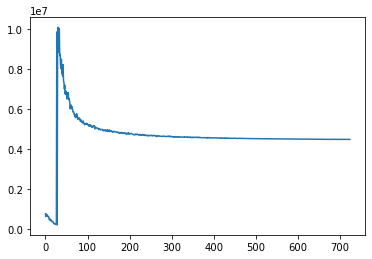

       mean       std        5%       95%
0 -0.628179  0.072009 -0.753238 -0.525898
1 -2.324013  0.092603 -2.463809 -2.178221
2  2.474566  0.079119  2.362216  2.601926
3 -1.929260  0.141076 -2.174099 -1.698627
4 -0.926321  0.175597 -1.273371 -0.642868
5 -1.238281  0.176254 -1.561359 -0.941346
{'mean': tensor([-0.6282, -2.3240,  2.4746, -1.9293, -0.9263, -1.2383]), 'std': tensor([0.0720, 0.0926, 0.0791, 0.1411, 0.1756, 0.1763]), '5%': tensor([-0.7532, -2.4638,  2.3622, -2.1741, -1.2734, -1.5614]), '95%': tensor([-0.5259, -2.1782,  2.6019, -1.6986, -0.6429, -0.9413])}


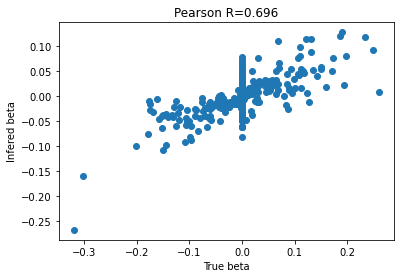

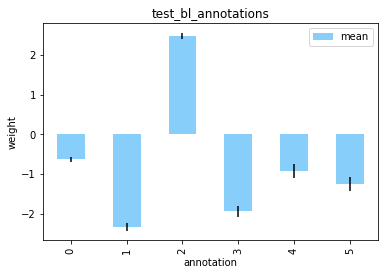

In [33]:
plt.plot(losses); plt.show()
plt.scatter(beta_true, beta)
plt.xlabel("True beta")
plt.ylabel("Infered beta")
plt.title("Pearson R=%1.3f" % scipy.stats.pearsonr(beta_true,beta)[0] )


  
## check anno
anno_df = pd.DataFrame.from_dict(stats["annotation_weights"] )
print(anno_df)
anno_df.reset_index().plot(x="index", y = 'mean', yerr='std',kind="bar", color='lightskyblue', title = "test_bl_annotations", ylabel='weight', xlabel='annotation')
print(stats["annotation_weights"]) # ideally should show large positive value for second entry, and close to 0 for third (noise)

# convert standardized beta to per-allele beta
if param_dict["beta_std"] == 'False':
    beta /= np.sqrt(2.0*sst_dict['MAF']*(1.0-sst_dict['MAF']))

sst_dict["beta_shrunk"] = beta

Reading annotations from 1 file(s)... 
Successfully loaded 5 annotations for 271699 SNPs 

Total of 991 SNPs after merging with sst 

Flipping annotaions for 756 rows
... SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 249 iterations. Increasing num_particles to 2.
Done after 181 iterations. Increasing num_particles to 4.
Done after 62 iterations. Increasing num_particles to 8.


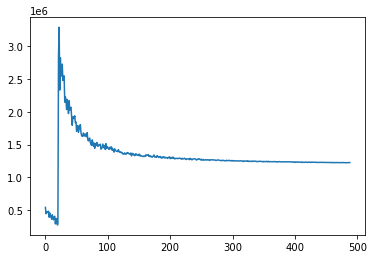

       mean       std        5%       95%
0 -0.682243  0.091731 -0.831833 -0.535675
1  2.582091  0.120392  2.368577  2.749328
2  1.032451  0.150576  0.803252  1.250319
3 -0.805564  0.412633 -1.584330 -0.165996
4 -1.524392  0.263134 -1.932302 -1.110138
5  0.773838  0.183252  0.433736  1.040695
{'mean': tensor([-0.6822,  2.5821,  1.0325, -0.8056, -1.5244,  0.7738]), 'std': tensor([0.0917, 0.1204, 0.1506, 0.4126, 0.2631, 0.1833]), '5%': tensor([-0.8318,  2.3686,  0.8033, -1.5843, -1.9323,  0.4337]), '95%': tensor([-0.5357,  2.7493,  1.2503, -0.1660, -1.1101,  1.0407])}


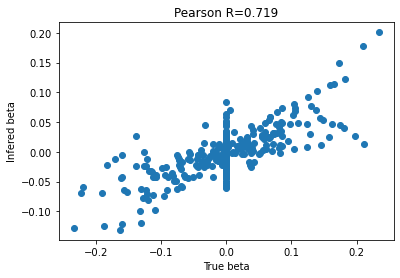

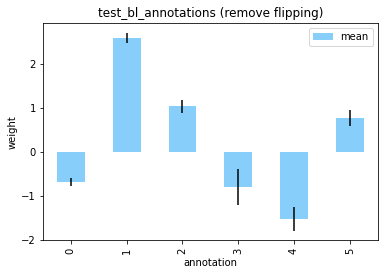

In [34]:
importlib.reload(parse_genet)
beta_true, beta_mrg, annotations = simulate_sumstats(ld_blk, blk_size, param_dict['n_gwas'], p = len(sst_dict),sst_dict = sst_dict, anno_path = bl_anno)
sst_dict["BETA"] = beta_mrg
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
importlib.reload(vi)
one = torch.tensor(1., device=device)

losses, beta, phi_est, stats = vi.vi(sst_dict, param_dict['n_gwas'], ld_blk, blk_size, device = device, annotations = annotations.float(), max_iterations = param_dict['n_iter'], max_particles=4, desired_min_eig = 1e-3, min_iterations = 200, stall_window = 30, phi_as_prior = False, lr = 0.03, constrain_sigma = True)


plt.plot(losses); plt.show()
plt.scatter(beta_true, beta)
plt.xlabel("True beta")
plt.ylabel("Infered beta")
plt.title("Pearson R=%1.3f" % scipy.stats.pearsonr(beta_true,beta)[0] )


  
## check anno
anno_df = pd.DataFrame.from_dict(stats["annotation_weights"] )
print(anno_df)
anno_df.reset_index().plot(x="index", y = 'mean', yerr='std',kind="bar", color='lightskyblue', title = "test_bl_annotations (remove flipping)", ylabel='weight', xlabel='annotation')
print(stats["annotation_weights"]) # ideally should show large positive value for second entry, and close to 0 for third (noise)

# convert standardized beta to per-allele beta
if param_dict["beta_std"] == 'False':
    beta /= np.sqrt(2.0*sst_dict['MAF']*(1.0-sst_dict['MAF']))

sst_dict["beta_shrunk"] = beta

In [6]:
def check_sim_result_loop(param_dict, title, iteration = 5, prop_nz= 0.2):
    if '1kg' in os.path.basename(param_dict['ref_dir']):
        ref_df = parse_genet.parse_ref(param_dict['ref_dir'] + '/snpinfo_1kg_hm3')
    elif 'ukbb' in os.path.basename(param_dict['ref_dir']):
        ref_df = parse_genet.parse_ref(param_dict['ref_dir'] + '/snpinfo_ukbb_hm3')

    ref_df = ref_df[ref_df.CHR == chrom]
    vld_df = parse_genet.parse_bim(param_dict['bim_prefix'] + ".bim")
    vld_df = vld_df[vld_df.CHR == chrom]
    sst_dict = parse_genet.parse_sumstats(ref_df, vld_df, param_dict['sst_file'], param_dict['n_gwas'])
    ld_blk, ld_blk_sym, blk_size = parse_genet.parse_ldblk(param_dict['ref_dir'], sst_dict, chrom)                                                                                                                                                                                 
    print("there are %s ld_blk" %(len(ld_blk)))
    
    pearsonr_list=[]
    anno_list=pd.DataFrame()

    for i in range(iteration):
        beta_true, beta_mrg, annotations = simulate.simulate_sumstats(ld_blk, blk_size, param_dict['n_gwas'], p = len(sst_dict), prop_nz = prop_nz)
        sst_dict["BETA"] = beta_mrg
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        importlib.reload(vi)
        one = torch.tensor(1., device=device)
        losses, beta, phi_est, stats = vi.vi(sst_dict, param_dict['n_gwas'], ld_blk, blk_size, device = device, annotations = annotations, max_iterations = param_dict['n_iter'], max_particles=4, desired_min_eig = 1e-3, min_iterations = 200, stall_window = 30, phi_as_prior = False, lr = 0.03, constrain_sigma = True)
            
        plt.plot(losses); plt.show()
        r=scipy.stats.pearsonr(beta_true,beta)[0]
        pearsonr_list.append(r)

        ## check anno
        anno_df = pd.DataFrame.from_dict(stats["annotation_weights"] )
        print(anno_df)
        anno_list = anno_list.append(anno_df["mean"].to_frame().T, ignore_index=True)  
        
    ## plot anno  
    plt.bar(anno_list.mean().index, anno_list.mean(), yerr=anno_list.std(), capsize=10, color='turquoise')
    labels = ['intervel', 'perfect anno', 'random anno']
    plt.xticks(anno_list.mean().index, labels)
    plt.ylabel('weight')
    plt.title('iterate %d times'%(iteration))
    plt.show()
    
    print(stats["annotation_weights"]) # ideally should show large positive value for second entry, and close to 0 for third (noise)

    ## plot r
    plt.plot(range(iteration), pearsonr_list, marker='o', linestyle='--', color='c')
    
    ax = plt.axes()
    ax.set_ylim(0.5, 1)
    plt.xticks(list(range(iteration)),list(range(iteration)))
    plt.title('pearson r for betas')
    plt.show()

    print(pearsonr_list)
    return(anno_list,pearsonr_list)        
#     # convert standardized beta to per-allele beta
#     if param_dict["beta_std"] == 'False':
#         beta /= np.sqrt(2.0*sst_dict['MAF']*(1.0-sst_dict['MAF']))

#     sst_dict["beta_shrunk"] = beta
    




## Test of simulation data, only using chr22 from test data

... parse reference file: /gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur/snpinfo_ukbb_hm3 ...
... parse sumstats file: test_data/sumstats.txt ...
... 991 common SNPs in the reference, sumstats, and validation set ...
... parse reference LD on chromosome 22 ...
there are 4 ld_blk
... SVI ...
Degenerate LD mat (min eigenvalue=-4.233e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 202 iterations. Increasing num_particles to 2.
Done after 127 iterations. Increasing num_particles to 4.
Done after 138 iterations. Increasing num_particles to 8.


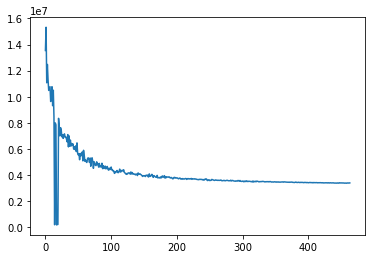

       mean       std        5%       95%
0  1.558509  0.145907  1.306454  1.791366
1  0.962018  0.148647  0.741711  1.187034
2 -0.132831  0.201178 -0.467998  0.188211
... SVI ...
Degenerate LD mat (min eigenvalue=-4.233e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 239 iterations. Increasing num_particles to 2.
Done after 67 iterations. Increasing num_particles to 4.
Done after 172 iterations. Increasing num_particles to 8.


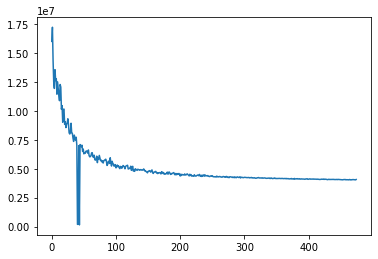

       mean       std        5%       95%
0  0.923575  0.299768  0.414109  1.330398
1  0.269896  0.308612 -0.247258  0.776182
2  0.852419  0.213065  0.481032  1.200091
... SVI ...
Degenerate LD mat (min eigenvalue=-4.233e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 212 iterations. Increasing num_particles to 2.
Done after 171 iterations. Increasing num_particles to 4.
Done after 110 iterations. Increasing num_particles to 8.


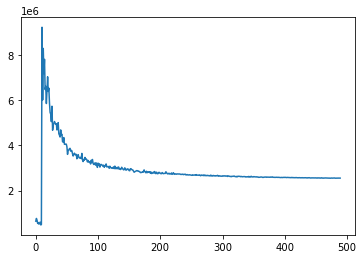

       mean       std        5%       95%
0 -1.154712  0.085966 -1.289150 -1.012341
1  0.453837  0.082308  0.315513  0.573296
2 -1.388511  0.086931 -1.558407 -1.231532
... SVI ...
Degenerate LD mat (min eigenvalue=-4.233e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 402 iterations. Increasing num_particles to 2.
Done after 89 iterations. Increasing num_particles to 4.
Done after 114 iterations. Increasing num_particles to 8.


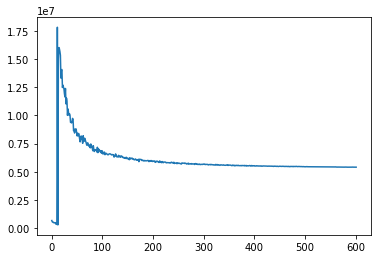

       mean       std        5%       95%
0  0.501563  0.092046  0.346270  0.643375
1  1.498573  0.079446  1.382906  1.643076
2 -0.718406  0.128969 -0.921800 -0.525665
... SVI ...
Degenerate LD mat (min eigenvalue=-4.233e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 257 iterations. Increasing num_particles to 2.
Done after 110 iterations. Increasing num_particles to 4.
Done after 106 iterations. Increasing num_particles to 8.


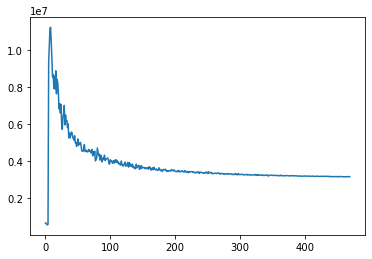

       mean       std        5%       95%
0  0.113497  0.103063 -0.050141  0.286173
1  0.392096  0.107039  0.210812  0.560778
2 -1.235465  0.091155 -1.383232 -1.100009
... SVI ...
Degenerate LD mat (min eigenvalue=-4.233e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 225 iterations. Increasing num_particles to 2.
Done after 199 iterations. Increasing num_particles to 4.
Done after 177 iterations. Increasing num_particles to 8.


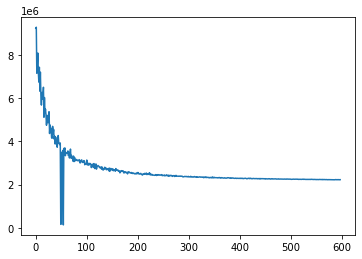

       mean       std        5%       95%
0  0.748208  0.246291  0.322588  1.105759
1  0.910354  0.396565  0.353043  1.527550
2 -1.053232  0.229291 -1.466735 -0.707732
... SVI ...
Degenerate LD mat (min eigenvalue=-4.233e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 359 iterations. Increasing num_particles to 2.
Done after 151 iterations. Increasing num_particles to 4.
Done after 148 iterations. Increasing num_particles to 8.


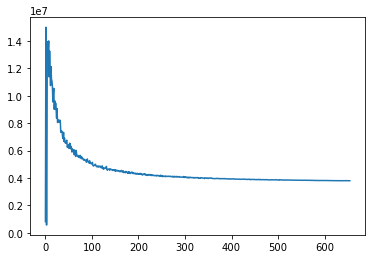

       mean       std        5%       95%
0 -0.772939  0.077680 -0.910880 -0.646643
1  2.160987  0.114329  1.974214  2.354386
2  1.228274  0.120978  1.039058  1.430202
... SVI ...
Degenerate LD mat (min eigenvalue=-4.233e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 296 iterations. Increasing num_particles to 2.
Done after 99 iterations. Increasing num_particles to 4.
Done after 128 iterations. Increasing num_particles to 8.


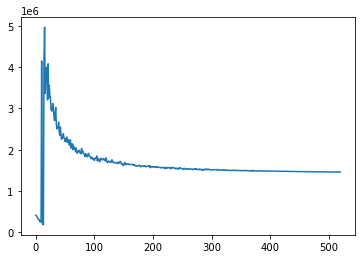

       mean       std        5%       95%
0  1.155202  0.094648  1.000407  1.321559
1  1.482959  0.086264  1.335953  1.596379
2 -0.072306  0.182993 -0.384178  0.204537
... SVI ...
Degenerate LD mat (min eigenvalue=-4.233e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 227 iterations. Increasing num_particles to 2.
Done after 133 iterations. Increasing num_particles to 4.
Done after 114 iterations. Increasing num_particles to 8.


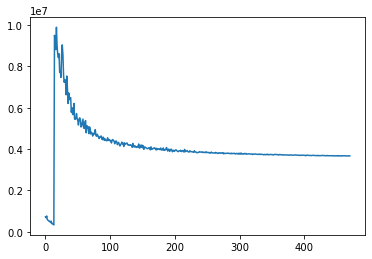

       mean       std        5%       95%
0  0.973780  0.174091  0.682977  1.218242
1 -1.059853  0.118007 -1.250899 -0.873423
2 -0.962467  0.110538 -1.149674 -0.820136
... SVI ...
Degenerate LD mat (min eigenvalue=-4.233e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 234 iterations. Increasing num_particles to 2.
Done after 151 iterations. Increasing num_particles to 4.
Done after 156 iterations. Increasing num_particles to 8.


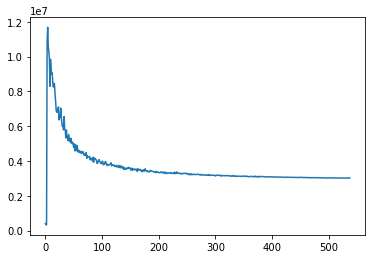

       mean       std        5%       95%
0  1.304015  0.091926  1.138057  1.468224
1  1.549430  0.087182  1.404418  1.684029
2 -0.480045  0.156308 -0.703865 -0.241313


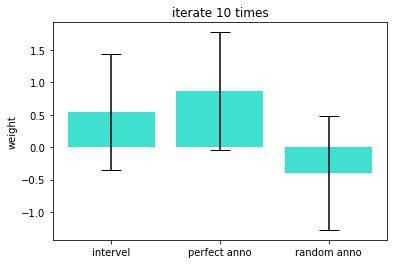

{'mean': tensor([ 1.3040,  1.5494, -0.4800]), 'std': tensor([0.0919, 0.0872, 0.1563]), '5%': tensor([ 1.1381,  1.4044, -0.7039]), '95%': tensor([ 1.4682,  1.6840, -0.2413])}


/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


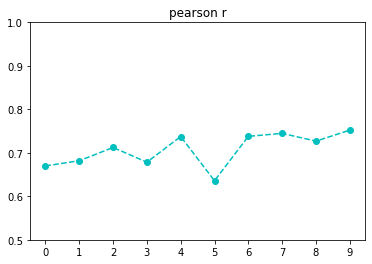

[0.6699252737867145, 0.6817366415061195, 0.7122644226024328, 0.6785080897600502, 0.7374209629468838, 0.6358918674486914, 0.7378732452719181, 0.7447379966052345, 0.7268784774228538, 0.7521735688955367]


In [132]:
chrom=22
param_dict = {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur', ## add my path
    'bim_prefix' : "test_data/test",
    'sst_file' : "test_data/sumstats.txt",
    'n_gwas' : 200000, 
    'out_dir' : "test_data",
    "seed" : 42, 
    "beta_std" : "False", 
    "n_iter" : 1000
}

anno_test = check_sim_result_loop(param_dict, "sim 1000 SNPs in CHR22", iteration=10)

## 'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur' ## ukbb
## 'ref_dir' : "../ld/ldblk_1kg_eur", 
## 'bim_prefix' : "test_data/test",


In [133]:
anno_test[0]

,0,1,2
0,1.558509,0.962018,-0.132831
1,0.923575,0.269896,0.852419
2,-1.154712,0.453837,-1.388511
3,0.501563,1.498573,-0.718406
4,0.113497,0.392096,-1.235465
5,0.748208,0.910354,-1.053232
6,-0.772939,2.160987,1.228274
7,1.155202,1.482959,-0.072306
8,0.973780,-1.059853,-0.962467
9,1.304015,1.549430,-0.480045


In [4]:
## test the beta in sumstats
import pandas as pd
import numpy as np
sumstat = pd.read_csv('test_data/sumstats.txt', sep = '\t')
print(sumstat.BETA.mean(), sumstat.BETA.std())


-9.330000000000005e-05 0.012583713878063382


In [52]:
## testing only using 1000 SNPs in summary stats in chr22
# observations: 
# collapsed >> uncollapsed (deleted uncollapsed code)
# phi_as_prior = False seems to give better results, but phi_as_prior = True gives more robust training (less noisy loss), probably because constraint on psi is more useful. 
# Does constrain_sigma help? I think constrain_psi does. 
# Seem to need desired_min_eig=1e-3 at least to avoid numerical issues. Could go lower if using float64 it seemed. 


In [4]:
annotations.shape

torch.Size([991, 3])

In [5]:
stats["annotation_weights"] 

{'mean': tensor([ 1.5686,  0.1555, -0.7184]),
 'std': tensor([0.1330, 0.1174, 0.1177]),
 '5%': tensor([ 1.3670, -0.0415, -0.9147]),
 '95%': tensor([ 1.7798,  0.3482, -0.4920])}

In [84]:
ld_blk[1].shape ##(173,173)
blk_size ## [134, 173, 507, 177]
p ## the interception SNP of sumstat, ref_ld, validate df

ld_blk, ld_blk_sym, blk_size = parse_genet.parse_ldblk(param_dict['ref_dir'], sst_dict, chrom)

[134, 173, 507, 177]

In [87]:
stats["annotation_weights"] 

991

... parse reference file: /gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur/snpinfo_ukbb_hm3 ...
... parse sumstats file: test_data/wightman_chr22.tsv ...
... 14014 common SNPs in the reference, sumstats, and validation set ...
... parse reference LD on chromosome 22 ...
there are 24 ld_blk
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03


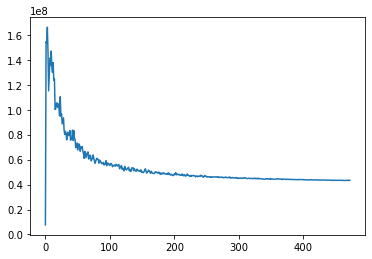

       mean       std        5%       95%
0 -0.455925  0.087000 -0.608210 -0.319303
1  0.717473  0.079256  0.551217  0.833432
2 -1.266708  0.108772 -1.454974 -1.113966
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

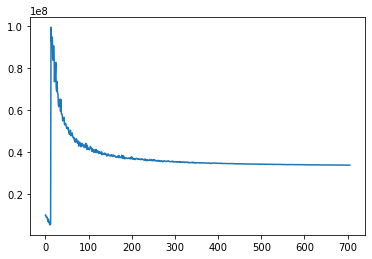

       mean       std        5%       95%
0 -0.650440  0.098642 -0.810978 -0.478541
1 -0.133448  0.083631 -0.275146 -0.003957
2  1.419999  0.071128  1.303378  1.535333
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

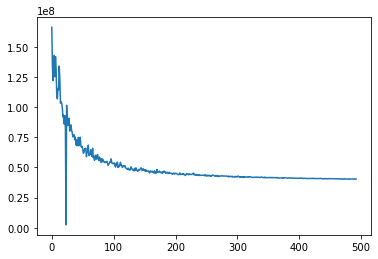

       mean       std        5%       95%
0  1.157213  0.164061  0.885079  1.399936
1  0.190127  0.176418 -0.108608  0.469435
2  0.832910  0.158211  0.584565  1.100665
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

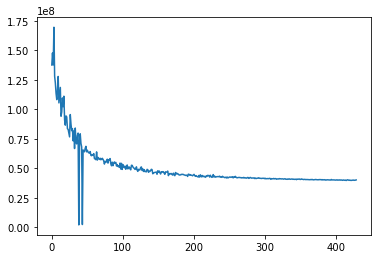

       mean       std        5%       95%
0  0.448358  0.302202 -0.062028  0.985891
1  0.242439  0.341661 -0.474328  0.742734
2  0.911534  0.220689  0.568360  1.257176
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

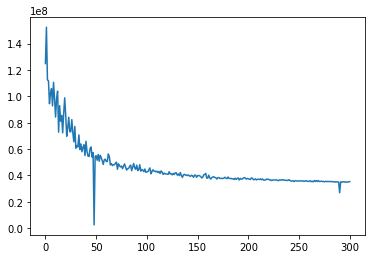

       mean       std        5%       95%
0  0.387550  0.256555 -0.102207  0.817071
1  0.877038  0.267554  0.375995  1.293593
2 -0.518689  0.368568 -1.162243  0.069663
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

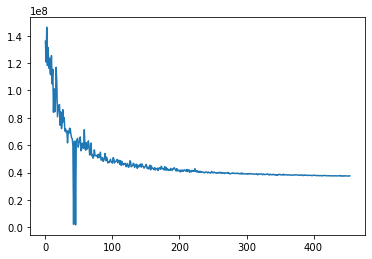

       mean       std        5%       95%
0  0.859656  0.281569  0.427253  1.323339
1  0.759933  0.230610  0.356285  1.152989
2  0.353156  0.312885 -0.167064  0.823504
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

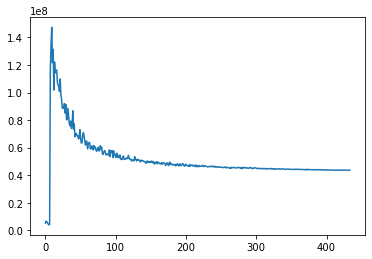

       mean       std        5%       95%
0  0.993982  0.097864  0.819816  1.148935
1  1.343361  0.136027  1.110945  1.533245
2 -0.526433  0.118832 -0.745339 -0.328228
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

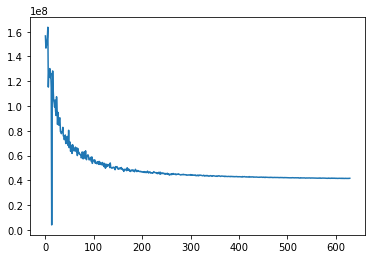

       mean       std        5%       95%
0  0.218754  0.170345 -0.047698  0.495845
1  0.042904  0.116386 -0.150176  0.224723
2 -0.954997  0.116400 -1.111843 -0.752040
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

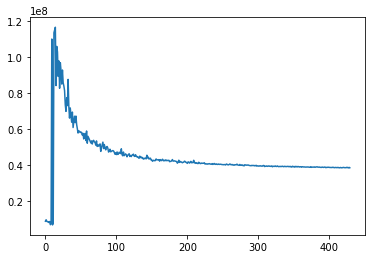

       mean       std        5%       95%
0 -0.944168  0.077141 -1.065274 -0.826210
1 -1.275051  0.130374 -1.492668 -1.067465
2  1.496700  0.107281  1.311948  1.670871
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

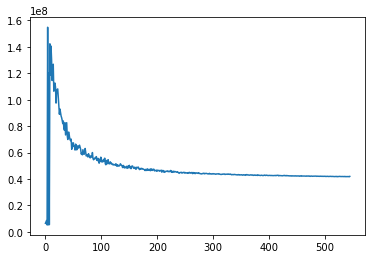

       mean       std        5%       95%
0 -0.203383  0.150384 -0.454674  0.036721
1  2.071481  0.075912  1.930627  2.204082
2 -0.773232  0.126027 -0.944816 -0.567115


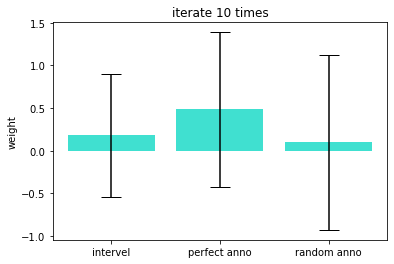

{'mean': tensor([-0.2034,  2.0715, -0.7732]), 'std': tensor([0.1504, 0.0759, 0.1260]), '5%': tensor([-0.4547,  1.9306, -0.9448]), '95%': tensor([ 0.0367,  2.2041, -0.5671])}


/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


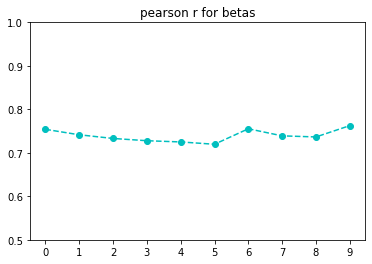

[0.7540347413419254, 0.7414992592807942, 0.7330411011572591, 0.7278447711594472, 0.7250157011890049, 0.7196752155753612, 0.7553155018153669, 0.739028726633243, 0.7365086723094462, 0.7625427005421034]


,0,1,2
0,-0.455925,0.717473,-1.266708
1,-0.650440,-0.133448,1.419999
2,1.157213,0.190127,0.832910
3,0.448358,0.242439,0.911534
4,0.387550,0.877038,-0.518689
5,0.859656,0.759933,0.353156
6,0.993982,1.343361,-0.526433
7,0.218754,0.042904,-0.954997
8,-0.944168,-1.275051,1.496700
9,-0.203383,2.071481,-0.773232


In [135]:
## using all chr22
param_dict = {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur', ## add my path
    'bim_prefix' : "test_data/ADSP_qc_chr22", 
    'sst_file' : "test_data/wightman_chr22.tsv", 
    'n_gwas' : 200000, 
    'out_dir' : "test_data",
    "seed" : 42, 
    "beta_std" : "False", 
    "n_iter" : 1000
}
anno_test = check_sim_result_loop(param_dict, "all SNPs in CHR22", iteration=10,prop_nz= 0.2)

anno_test[0]

... parse reference file: /gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur/snpinfo_ukbb_hm3 ...
... parse sumstats file: test_data/wightman_chr22.tsv ...
... 14014 common SNPs in the reference, sumstats, and validation set ...
... parse reference LD on chromosome 22 ...
there are 24 ld_blk
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03


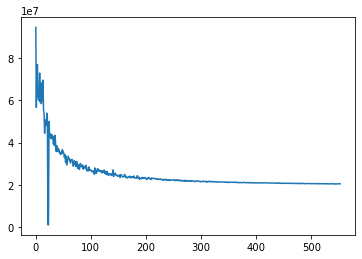

       mean       std        5%       95%
0  0.852311  0.159638  0.549266  1.101703
1  1.121508  0.199090  0.776067  1.477988
2 -0.542142  0.166237 -0.839772 -0.257790
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

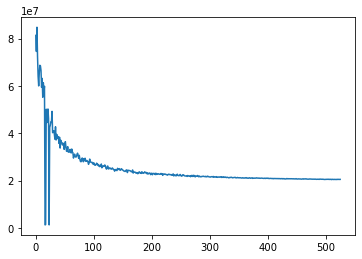

       mean       std        5%       95%
0  1.045447  0.112015  0.858583  1.225116
1  1.253785  0.113260  1.082610  1.426316
2  0.069452  0.195386 -0.287212  0.351945
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

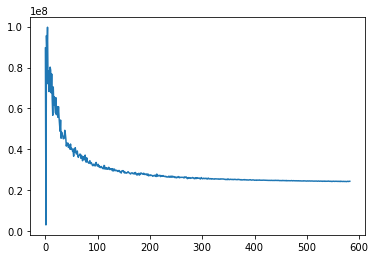

       mean       std        5%       95%
0  0.131431  0.085347 -0.024148  0.266158
1  2.011606  0.100487  1.849313  2.173088
2  0.604783  0.082840  0.460512  0.746551


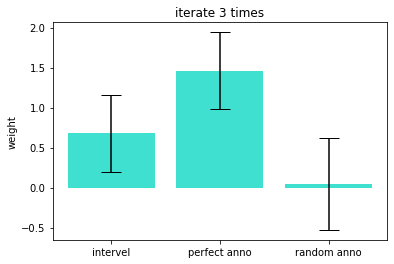

{'mean': tensor([0.1314, 2.0116, 0.6048]), 'std': tensor([0.0853, 0.1005, 0.0828]), '5%': tensor([-0.0241,  1.8493,  0.4605]), '95%': tensor([0.2662, 2.1731, 0.7466])}


/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


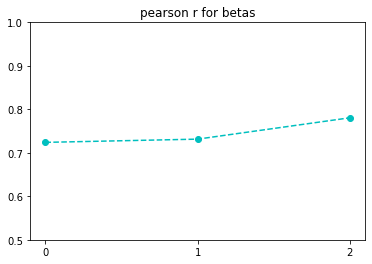

[0.7240608719026866, 0.7314758152323326, 0.7805293840471507]


,0,1,2
0,0.852311,1.121508,-0.542142
1,1.045447,1.253785,0.069452
2,0.131431,2.011606,0.604783


In [19]:
## using more stringent prop_nz


param_dict = {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur', ## add my path
    'bim_prefix' : "test_data/ADSP_qc_chr22", 
    'sst_file' : "test_data/wightman_chr22.tsv", 
    'n_gwas' : 200000, 
    'out_dir' : "test_data",
    "seed" : 42, 
    "beta_std" : "False", 
    "n_iter" : 1000
}
importlib.reload(vi)
anno_test = check_sim_result_loop(param_dict, "all SNPs in CHR22", iteration=3,prop_nz= 0.1)

anno_test[0]

In [20]:
loss_np = np.array(losses)
indices = np.where(loss_np < 1e7)[0]

# Print values and their corresponding indices
for index in indices:
    print(f"Value {loss_np[index]} at index {index}")

Value 2530739.7761394978 at index 56
Value 2474466.6801837683 at index 60
Value 1457925.2138929367 at index 141


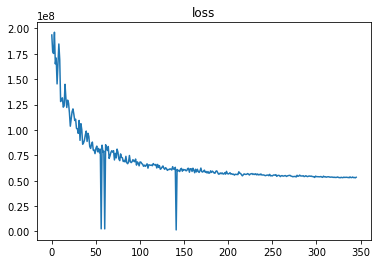

In [22]:
plt.plot(losses); plt.title('loss');plt.show()

... parse reference file: /gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_1kg_eur/snpinfo_1kg_hm3 ...
... parse sumstats file: test_data/wightman_chr22.tsv ...
... 14130 common SNPs in the reference, sumstats, and validation set ...
... parse reference LD on chromosome 22 ...
there are 24 ld_blk
... SVI ...
Degenerate LD mat (min eigenvalue=-3.739e-07), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-7.873e-07), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.630e-06), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.276e-06), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.458e-06), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.766e-06), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-4.344e-06), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.486e-06), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-4.003e-06), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.808e-06), fixing to 1.000e-03
De

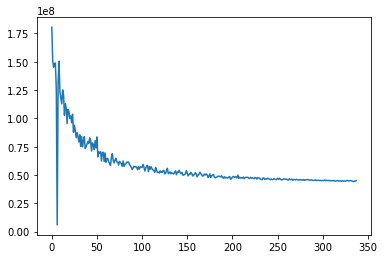

       mean       std        5%       95%
0  0.134044  0.096270 -0.014506  0.307582
1  0.401788  0.113878  0.211145  0.561761
2 -1.153563  0.106468 -1.318990 -1.005556
{'mean': tensor([ 0.1340,  0.4018, -1.1536]), 'std': tensor([0.0963, 0.1139, 0.1065]), '5%': tensor([-0.0145,  0.2111, -1.3190]), '95%': tensor([ 0.3076,  0.5618, -1.0056])}


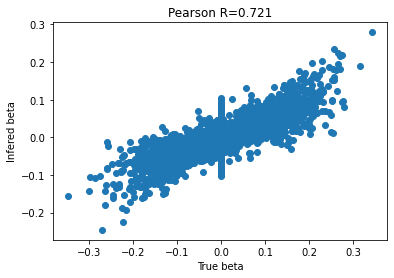

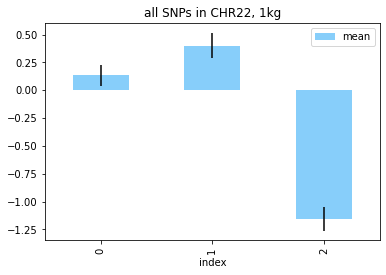

In [40]:
## using all chr22 ## 1kg
param_dict = {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_1kg_eur', ## add my path
    'bim_prefix' : "test_data/ADSP_qc_chr22", 
    'sst_file' : "test_data/wightman_chr22.tsv", 
    'n_gwas' : 200000, 
    'out_dir' : "test_data",
    "seed" : 42, 
    "beta_std" : "False", 
    "n_iter" : 1000
}

check_sim_result(param_dict, "all SNPs in CHR22, 1kg")


## testing to make the first anno 100% accurate

<AxesSubplot:title={'center':'title'}, xlabel='annotation', ylabel='weight'>

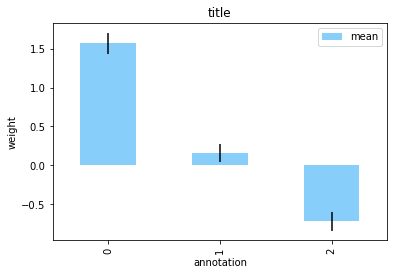

In [45]:
anno_df.reset_index().plot(x="index", y = 'mean', yerr='std',kind="bar", color='lightskyblue', title = 'title', ylabel='weight', xlabel='annotation')

## check simulation with annotaitons


In [4]:
bl_anno='/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/annotations/annotations_high_h2/baseline/baseline_high_h2_chr'
deepsea='/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/annotations/annotations_high_h2/deepsea/deepsea_high_h2_chr'
enformer='/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/annotations/annotations_high_h2/enformer/enformer_high_h2_chr'

anno_file = bl_anno+','+deepsea+','+enformer

In [23]:
param_dict = {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur', ## add my path
    'bim_prefix' : "test_data/test",
    'sst_file' : "test_data/sumstats.txt",
    'n_gwas' : 200000, 
    'out_dir' : "test_data",
    "seed" : 42, 
    "beta_std" : "False", 
    "n_iter" : 1000
}

anno_test = check_sim_result(param_dict, "1000SNPs with real annotations", bl_anno)

... parse reference file: /gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur/snpinfo_ukbb_hm3 ...
... parse sumstats file: test_data/sumstats.txt ...
... 991 common SNPs in the reference, sumstats, and validation set ...
... parse reference LD on chromosome 22 ...
there are 4 ld_blk
Reading annotations from 1 file(s)... 
Successfully loaded 5 annotations for 271699 SNPs 

Total of 991 SNPs after merging with sst 

Flipping annotaions for 756 rows
Total of 0 annotations after only picking the binary ones 

... SVI ...
Degenerate LD mat (min eigenvalue=-4.233e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03


RuntimeError: expected scalar type Double but found Float
          Trace Shapes:    
           Param Sites:    
          Sample Sites:    
annotation_weights dist | 1
                  value | 1
Trace Shapes:
 Param Sites:
Sample Sites: